In [1]:
from keras import layers, models, optimizers
from keras import backend as K

import numpy as np
from numpy.random import choice
import math
import random
from collections import namedtuple, deque


class Actor:
    
    
  # """Actor (policy) Model. """

    def __init__(self, state_size, action_size):

        self.state_size = state_size
        self.action_size = action_size

        self.build_model()

    def build_model(self):
        states = layers.Input(shape=(self.state_size,), name='states')
        
        net = layers.Dense(units=32,kernel_regularizer=layers.regularizers.l2(1e-6))(states)
        net = layers.BatchNormalization()(net)
        net = layers.Activation("relu")(net)
        net = layers.Dense(units=32,kernel_regularizer=layers.regularizers.l2(1e-6))(net)
        net = layers.BatchNormalization()(net)
        net = layers.Dense(units=32,kernel_regularizer=layers.regularizers.l2(1e-6))(net)
        net = layers.BatchNormalization()(net)
        net = layers.Activation("relu")(net)

        actions = layers.Dense(units=self.action_size, activation='softmax', name = 'actions')(net)
        
        self.model = models.Model(inputs=states, outputs=actions)

        action_gradients = layers.Input(shape=(self.action_size,))
        loss = K.mean(-action_gradients * actions)

        optimizer = optimizers.Adam(lr=.000001)
        updates_op = optimizer.get_updates(params=self.model.trainable_weights, loss=loss)
        self.train_fn = K.function(
            inputs=[self.model.input, action_gradients, K.learning_phase()],
            outputs=[],
            updates=updates_op)

Using TensorFlow backend.


In [2]:
class Critic:
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
        """
        self.state_size = state_size
        self.action_size = action_size

        self.build_model()

    def build_model(self):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        # Define input layers
        states = layers.Input(shape=(self.state_size,), name='states')
        actions = layers.Input(shape=(self.action_size,), name='actions')

        net_states = layers.Dense(units=16,kernel_regularizer=layers.regularizers.l2(1e-6))(states)
        net_states = layers.BatchNormalization()(net_states)
        net_states = layers.Activation("relu")(net_states)

        net_states = layers.Dense(units=32, kernel_regularizer=layers.regularizers.l2(1e-6))(net_states)

        net_actions = layers.Dense(units=32,kernel_regularizer=layers.regularizers.l2(1e-6))(actions)

        net = layers.Add()([net_states, net_actions])
        net = layers.Activation('relu')(net)

        Q_values = layers.Dense(units=1, name='q_values',kernel_initializer=layers.initializers.RandomUniform(minval=-0.003, maxval=0.003))(net)

        self.model = models.Model(inputs=[states, actions], outputs=Q_values)

        optimizer = optimizers.Adam(lr=0.0001)
        self.model.compile(optimizer=optimizer, loss='mse')

        action_gradients = K.gradients(Q_values, actions)

        self.get_action_gradients = K.function(
            inputs=[*self.model.input, K.learning_phase()],
            outputs=action_gradients)

In [3]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
    
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self, batch_size=32):
        return random.sample(self.memory, k=self.batch_size)
    
    def __len__(self):
        return len(self.memory)
    
    
class Agent:
    def __init__(self, state_size, batch_size, is_eval = False):
        self.state_size = state_size
        self.action_size = 3
        self.buffer_size = 1000000
        self.batch_size = batch_size
        self.memory = ReplayBuffer(self.buffer_size, self.batch_size)
        self.inventory = []
        self.is_eval = is_eval
        
        self.gamma = 0.99
        self.tau = 0.001
        
        self.actor_local = Actor(self.state_size, self.action_size)
        self.actor_target = Actor(self.state_size, self.action_size)    

        self.critic_local = Critic(self.state_size, self.action_size)
        self.critic_target = Critic(self.state_size, self.action_size)
        
        self.critic_target.model.set_weights(self.critic_local.model.get_weights()) 
        self.actor_target.model.set_weights(self.actor_local.model.get_weights())
        
    def act(self, state):
        options = self.actor_local.model.predict(state)
        self.last_state = state
        if not self.is_eval:
            return choice(range(0,3), p = options[0])
        return np.argmax(options[0])
    
    def step(self, action, reward, next_state, done):
        self.memory.add(self.last_state, action, reward, next_state, done)
        if len(self.memory) > self.batch_size:
            experiences = self.memory.sample(self.batch_size)
            loss = self.learn(experiences)
            self.last_state = next_state
            return loss

    def learn(self, experiences):               
        states = np.vstack([e.state for e in experiences if e is not None]).astype(np.float32).reshape(-1,self.state_size)    
        actions = np.vstack([e.action for e in experiences if e is not None]).astype(np.float32).reshape(-1,self.action_size)
        rewards = np.array([e.reward for e in experiences if e is not None]).astype(np.float32).reshape(-1,1)
        dones = np.array([e.done for e in experiences if e is not None]).astype(np.float32).reshape(-1,1)
        next_states = np.vstack([e.next_state for e in experiences if e is not None]).astype(np.float32).reshape(-1,self.state_size)

        actions_next = self.actor_target.model.predict_on_batch(next_states)
        Q_targets_next = self.critic_target.model.predict_on_batch([next_states, actions_next])
        
        Q_targets = rewards + self.gamma * Q_targets_next * (1 - dones)
        loss = self.critic_local.model.train_on_batch(x = [states, actions], y=Q_targets)
        
        action_gradients = np.reshape(self.critic_local.get_action_gradients([states, actions, 0]),(-1, self.action_size))
        self.actor_local.train_fn([states, action_gradients, 1])
        self.soft_update(self.critic_local.model, self.critic_target.model)  
        self.soft_update(self.actor_local.model, self.actor_target.model)
        return loss

    def soft_update(self, local_model, target_model):
        local_weights = np.array(local_model.get_weights())
        target_weights = np.array(target_model.get_weights())

        assert len(local_weights) == len(target_weights)

        new_weights = self.tau * local_weights + (1 - self.tau) * target_weights
        target_model.set_weights(new_weights)

In [4]:
def formatPrice(n):
    if n >= 0:
        curr = "$"
    else:
        curr = "-$"
    return curr + "{0:.2f}".format(abs(n))


def getStockData(key):
    datavec = []
    lines = open("data/" + key + ".csv", "r").read().splitlines()
    
    for line in lines[1:]:
        datavec.append(float(line.split(",")[1]))
    
    return datavec
  

def getState(data, t, window):
    if t - window >= -1:
        vec = data[t - window + 1:t + 1]
    else: 
        vec = -(t-window+1)*[data[0]]+data[0: t + 1]
    scaled_state = []
    for i in range(0,window - 1):
        scaled_state.append(1/(1 + math.exp(vec[i] - vec[i+1])))
    
    return np.array([scaled_state])

In [5]:
window_size = 50
batch_size = 32
agent = Agent(window_size, batch_size)
data = getStockData("train_set")
l = len(data) - 1
episode_count = 300
loss_list = []
total_profit_list = []
test_profit_list = []

for e in range(episode_count):
    print("Episode " + str(e) + "/" + str(episode_count))
    state = getState(data, 0, window_size + 1)

    agent.inventory = []
    total_profit = 0
    done = False
    for t in range(l):
        action = agent.act(state)
        action_prob = agent.actor_local.model.predict(state)

        next_state = getState(data, t + 1, window_size + 1)
        reward = 0

        if action == 1:
            agent.inventory.append(data[t])
            #print("Buy:" + formatPrice(data[t]))

        elif action == 2 and len(agent.inventory) > 0:
            bought_price = agent.inventory.pop(0)
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            #print("sell: " + formatPrice(data[t]) + "| profit: " + formatPrice(data[t] - bought_price))

        if t == l - 1:
            done = True
        loss = agent.step(action_prob, reward, next_state, done)
        state = next_state
        loss_list.append(loss)

        if done:
            total_profit_list.append(total_profit)
            #print("------------------------------------------")
            #print("Total Profit: " + formatPrice(total_profit))
            #print("------------------------------------------")

test_data = getStockData("test_set")
l_test = len(test_data) - 1
state = getState(test_data, 0, window_size + 1)
total_profit = 0
agent.inventory = []
agent.is_eval = False
done = False
for t in range(l_test):
    action = agent.act(state)

    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0

    if action == 1:

        agent.inventory.append(test_data[t])
        #print("Buy: " + formatPrice(test_data[t]))

    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        reward = max(test_data[t] - bought_price, 0)
        profit = test_data[t] - bought_price
        total_profit += profit
        test_profit_list.append(profit)
        #print("Sell: " + formatPrice(test_data[t]) + " | profit: " + formatPrice(test_data[t] - bought_price))

    if t == l_test - 1:
        done = True
    agent.step(action_prob, reward, next_state, done)
    state = next_state

    if done:
        pass
        #print("------------------------------------------")
        #print("Total Profit: " + formatPrice(total_profit))
        #print("------------------------------------------")
        
loss_list = list(filter(None, loss_list))














Episode 0/300


C:\Users\fonzi\.conda\envs\tf_115\lib\site-packages\ipykernel_launcher.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\fonzi\.conda\envs\tf_115\lib\site-packages\ipykernel_launcher.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Episode 1/300
Episode 2/300
Episode 3/300
Episode 4/300
Episode 5/300
Episode 6/300
Episode 7/300
Episode 8/300
Episode 9/300
Episode 10/300
Episode 11/300
Episode 12/300
Episode 13/300
Episode 14/300
Episode 15/300
Episode 16/300
Episode 17/300
Episode 18/300
Episode 19/300
Episode 20/300
Episode 21/300
Episode 22/300
Episode 23/300
Episode 24/300
Episode 25/300
Episode 26/300
Episode 27/300
Episode 28/300
Episode 29/300
Episode 30/300
Episode 31/300
Episode 32/300
Episode 33/300
Episode 34/300
Episode 35/300
Episode 36/300
Episode 37/300
Episode 38/300
Episode 39/300
Episode 40/300
Episode 41/300
Episode 42/300
Episode 43/300
Episode 44/300
Episode 45/300
Episode 46/300
Episode 47/300
Episode 48/300
Episode 49/300
Episode 50/300
Episode 51/300
Episode 52/300
Episode 53/300
Episode 54/300
Episode 55/300
Episode 56/300
Episode 57/300
Episode 58/300
Episode 59/300
Episode 60/300
Episode 61/300
Episode 62/300
Episode 63/300
Episode 64/300
Episode 65/300
Episode 66/300
Episode 67/300
Epis

In [6]:
len(test_profit_list)

11

In [7]:
len(total_profit_list)

300

In [8]:
len(loss_list)

981568

In [9]:
import matplotlib.pyplot as plt

def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err *= 1.96
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

    plt.show()

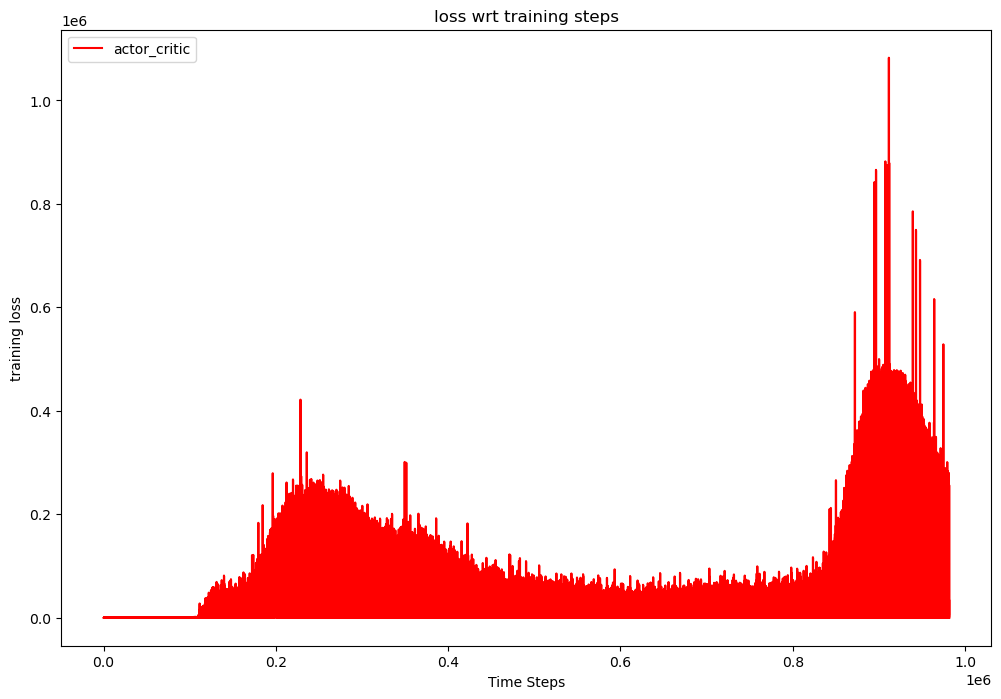

In [10]:
plot_curves([np.array([loss_list])], ['actor_critic'], ['r'], 'training loss', 'loss wrt training steps')

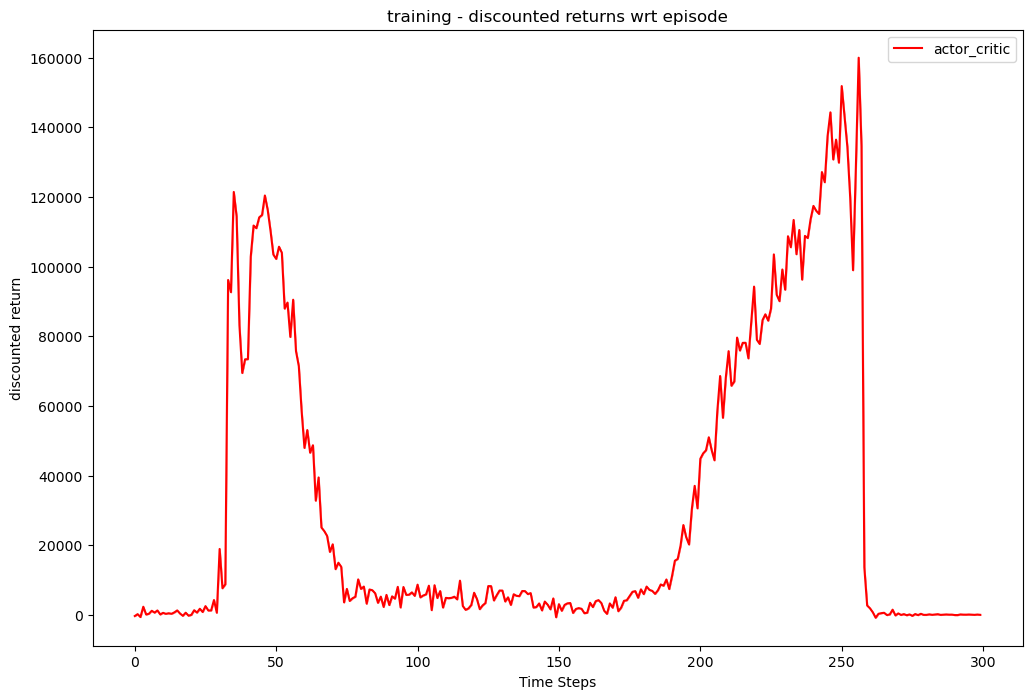

In [11]:
plot_curves([np.array([total_profit_list])], ['actor_critic'], ['r'], 'discounted return', 'training - discounted returns wrt episode')

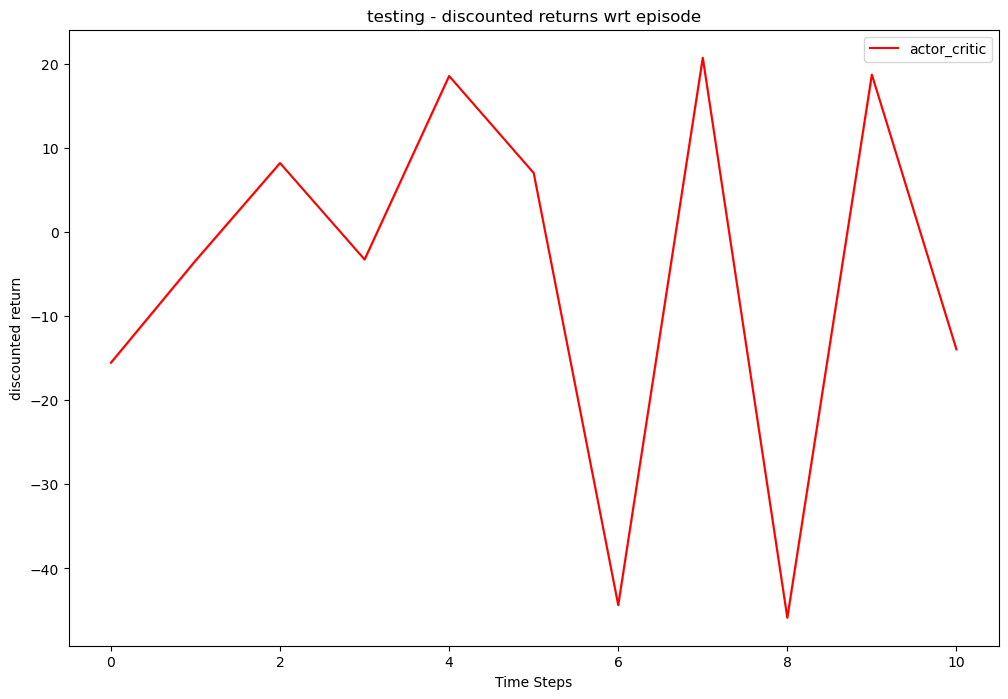

In [12]:
plot_curves([np.array([test_profit_list])], ['actor_critic'], ['r'], 'discounted return', 'testing - discounted returns wrt episode')

In [13]:
test_profit_list = []

test_data = getStockData("test_set")
l_test = len(test_data) - 1
state = getState(test_data, 0, window_size + 1)
total_profit = 0
agent.inventory = []
agent.is_eval = False
done = False
for t in range(l_test):
    action = agent.act(state)

    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0

    if action == 1:

        agent.inventory.append(test_data[t])
        #print("Buy: " + formatPrice(test_data[t]))

    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        reward = max(test_data[t] - bought_price, 0)
        profit = test_data[t] - bought_price
        total_profit += profit
        test_profit_list.append(profit)
        #print("Sell: " + formatPrice(test_data[t]) + " | profit: " + formatPrice(test_data[t] - bought_price))

    if t == l_test - 1:
        done = True
    agent.step(action_prob, reward, next_state, done)
    state = next_state

    if done:
        pass

C:\Users\fonzi\.conda\envs\tf_115\lib\site-packages\ipykernel_launcher.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\fonzi\.conda\envs\tf_115\lib\site-packages\ipykernel_launcher.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [14]:
train_profit_list = []

test_data = getStockData("train_set")
l_test = len(test_data) - 1
state = getState(test_data, 0, window_size + 1)
total_profit = 0
agent.inventory = []
agent.is_eval = False
done = False
for t in range(l_test):
    action = agent.act(state)

    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0

    if action == 1:

        agent.inventory.append(test_data[t])
        #print("Buy: " + formatPrice(test_data[t]))

    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        reward = max(test_data[t] - bought_price, 0)
        profit = test_data[t] - bought_price
        total_profit += profit
        train_profit_list.append(profit)
        #print("Sell: " + formatPrice(test_data[t]) + " | profit: " + formatPrice(test_data[t] - bought_price))

    if t == l_test - 1:
        done = True
    agent.step(action_prob, reward, next_state, done)
    state = next_state

    if done:
        pass

C:\Users\fonzi\.conda\envs\tf_115\lib\site-packages\ipykernel_launcher.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\fonzi\.conda\envs\tf_115\lib\site-packages\ipykernel_launcher.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


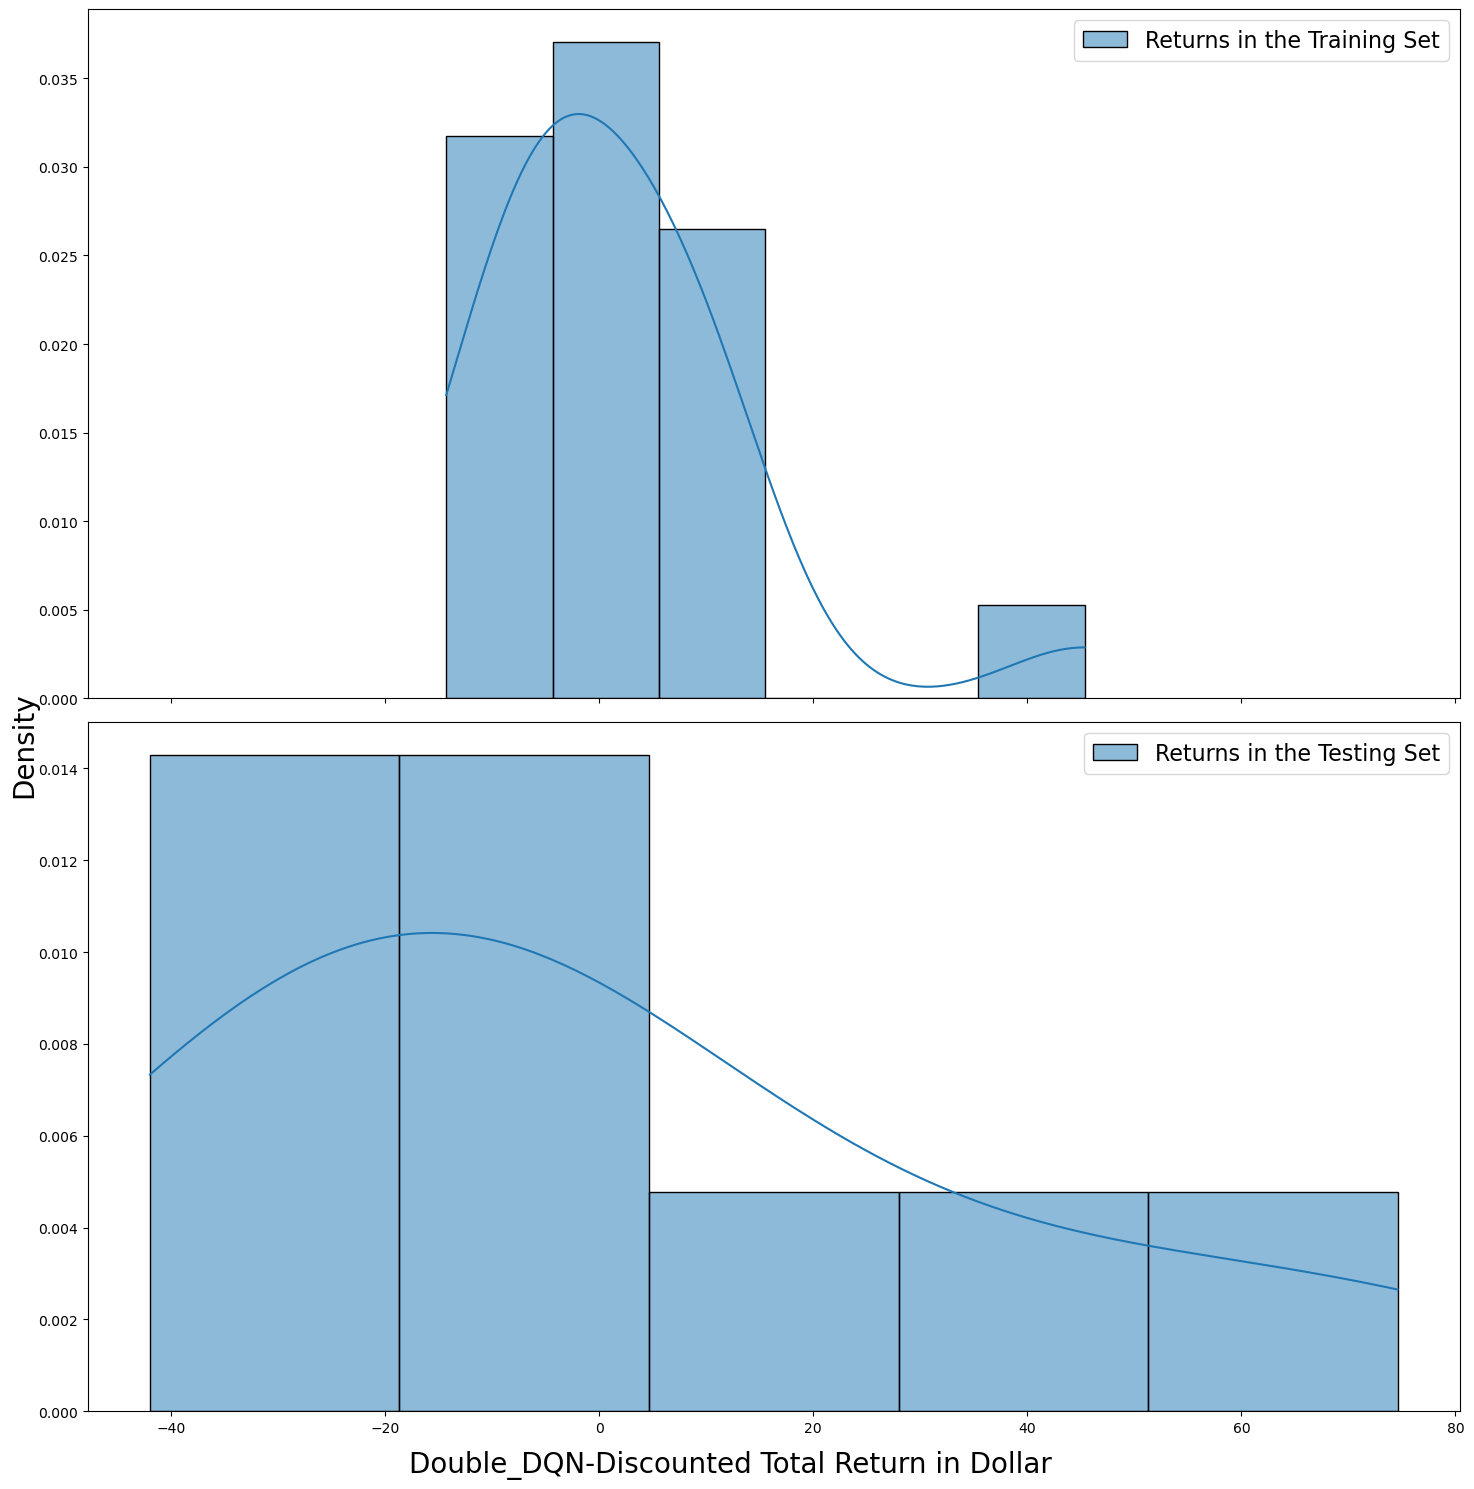

In [15]:
import seaborn as sns

def adjacent_plots(input_lists):
    '''
    Create subplots that share a common x-axis
    Subplots include the unconditional return plot and other conditional
    on key words plots
    '''
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15, 15))
    sns.histplot(input_lists[0], stat="density", label=f"Returns in the Training Set",
                 kde=True, fill=True, ax=axs[0]).set(xlabel=None, ylabel=None)
    sns.histplot(input_lists[1], stat="density", label=f'Returns in the Testing Set',
                 kde=True, fill=True, ax=axs[1]).set(xlabel=None, ylabel=None)
    #axs[0].set_xlim(0,5)
    axs[0].legend(loc="upper right", prop={"size": 16})
    axs[1].legend(loc="upper right", prop={"size": 16})
    fig.supxlabel("Double_DQN-Discounted Total Return in Dollar", fontsize=20)
    fig.supylabel("Density", fontsize=20)
    plt.tight_layout()
    plt.show()
adjacent_plots([train_profit_list, test_profit_list])